# Analiza wyników f-AnoGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Model

In [2]:
df = pd.read_csv('results_cropped_15_15/score.csv')

In [3]:
df

,label,img_distance,anomaly_score,z_distance
0,0,0.003181,0.007183,0.002731
1,1,0.072454,0.096608,0.028391
2,0,0.045306,0.062034,0.018470
3,1,0.054217,0.068767,0.024214
4,1,0.066026,0.096980,0.023439
...,...,...,...,...
32763,1,0.058789,0.076566,0.019881
32764,1,0.056651,0.077496,0.020988
32765,1,0.097383,0.127681,0.027947
32766,1,0.090627,0.204682,0.037630


In [4]:
# Opcjonalnie dla scorev.csv
# df.columns = ['label', 'imgdist', 'anomaly_score', 'zdist']

In [5]:
df.groupby('label').aggregate('mean')

,img_distance,anomaly_score,z_distance
label,,,
0,0.077066,0.099689,0.027754
1,0.079009,0.112805,0.032142


In [6]:
df_results = pd.DataFrame()
df_results['label'] = [0, 1]
df_results['mean_anomaly_score'] = df.groupby('label').aggregate('mean')['anomaly_score']
df_results['median_an_sc'] = df.groupby('label').aggregate('median')['anomaly_score']
df_results['max_an_sc'] = df.groupby('label').aggregate('max')['anomaly_score']
df_results.set_index('label', inplace=True)
df_results

,mean_anomaly_score,median_an_sc,max_an_sc
label,,,
0,0.099689,0.100745,0.746071
1,0.112805,0.103960,0.542333


Na pierwszy rzut oka wartości się szczególnie nie różnią

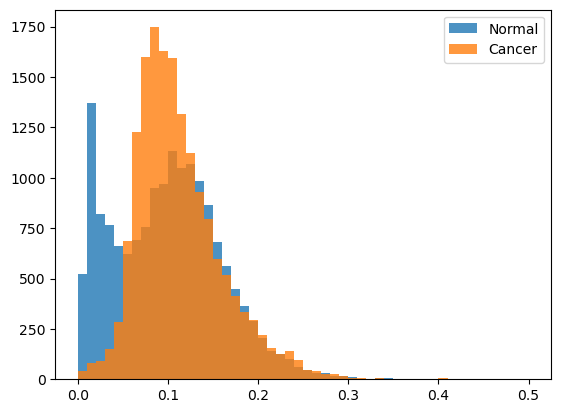

In [7]:
plt.hist(df[df['label'] == 0]['anomaly_score'], bins=50, range=(0, 0.5), label='Normal', alpha=0.8)
plt.hist(df[df['label'] == 1]['anomaly_score'], bins=50, range=(0, 0.5), label='Cancer', alpha=0.8)
plt.legend()
plt.show()

Histogram także nie wygląda najlepiej. Co prawda normalne dane często uzyskują anomaly score bliski zeru, to jednak histogramy się mocno pokrywają. Chcielibyśmy stworzyć jakieś narzędzie które będzie klasyfikowało czy dane zdjęcie jest anomalią czy nie (w naszym przypadku czy zawiera komórki rakowe na podstawie anomaly score)

In [8]:
# Wynikową ramkę dzielimy na zbiór treningowy (do wytrenowania naszego 'klasyfikatora') i na zbiór testowy
X_train, X_test, y_train, y_test = train_test_split(df['anomaly_score'], df['label'], test_size=0.4, random_state=42)

In [9]:
class Classificator_Demo:
    def __init__(self, cut_off):
        self.cut_off = cut_off
        
    def predict(self, X):
        predictions = (X > self.cut_off)
        return predictions

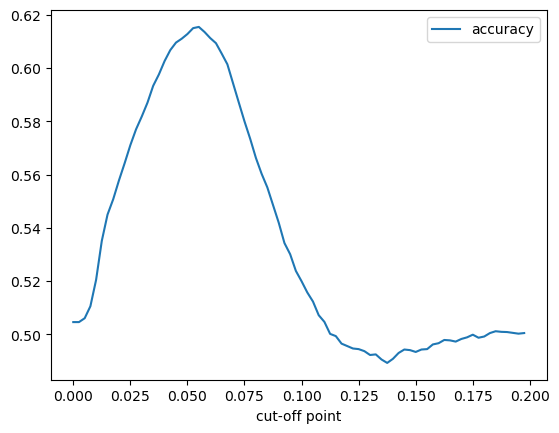

In [10]:
# Znajdźmy odpowiedni punkt odcięcia dla anomaly score
points_c = []
accuracy_c = []
for i in range(80):
    point = i / 400
    classifier = Classificator_Demo(cut_off=point)
    points_c.append(point)
    y_pred = classifier.predict(X_test)
    accuracy_c.append(accuracy_score(y_test, y_pred))
plt.plot(points_c, accuracy_c, label='accuracy')
plt.xlabel('cut-off point')
plt.legend()
plt.savefig('photos/cutoff.png', transparent=True)
plt.show()

In [11]:
print(f'optimal cut-off: {points_c[accuracy_c.index(max(accuracy_c))]}')

optimal cut-off: 0.055


Jednakże punkt odcięcia zależy od tego jak został wytrenowany generator, więc punkt odcięcia powinien zależec od wyników anomaly score ze zbioru treningowego. Weźmy średnie anomaly score dla danych zdrowych i chorych, dodajmy je i przemnóżmy przez pewną stałą k. Tej stałej będziemy szukać.

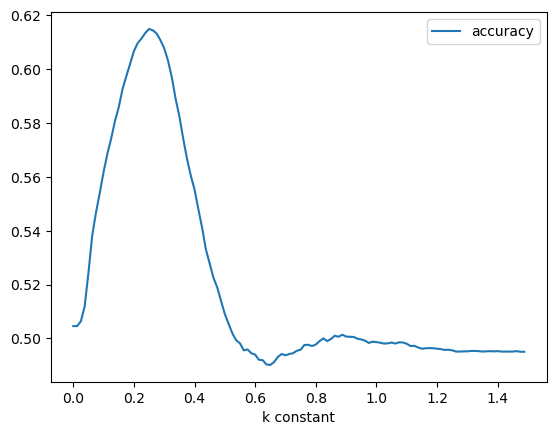

In [12]:
points_k = []
accuracy_k = []
for i in range(120):
    df0 = pd.DataFrame()
    df0['label'] = y_train
    df0['values'] = X_train
    df_agg0 = df0.groupby('label').aggregate('mean')
    k = i / 80
    point = k * (df_agg0.loc[0, 'values'] + df_agg0.loc[1, 'values'])
    classifier = Classificator_Demo(cut_off=point)
    points_k.append(k)
    y_pred = classifier.predict(X_test)
    accuracy_k.append(accuracy_score(y_test, y_pred))
plt.plot(points_k, accuracy_k, label='accuracy')
plt.xlabel('k constant')
plt.legend()
plt.savefig('photos/kpoint.png', transparent=True)
plt.show()

In [13]:
print(f'optimal k: {points_k[accuracy_k.index(max(accuracy_k))]}')
print(f"cut off point value: {(df_agg0.loc[0, 'values'] + df_agg0.loc[1, 'values']) * points_k[accuracy_k.index(max(accuracy_k))]}")

optimal k: 0.25
cut off point value: 0.05315925382723023


In [14]:
# Sprawdźmy czy takie same wartości otrzymują inne generatory
df1 = pd.read_csv('results_default_30_20/score.csv')
df2 = pd.read_csv('results_cropped_15_15/score.csv')
df3 = pd.read_csv('results_cropped_7_10/score.csv')
df4 = pd.read_csv('results_validation_50_20/scorev.csv')
df5 = pd.read_csv('results_stain_net/score.csv')
df4.columns = ['label', 'imgdist', 'anomaly_score', 'zdist']
data_frames = [df1, df2, df3, df4, df5]
optimal_constants = []
for df_test in data_frames:
    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(df_test['anomaly_score'], df_test['label'], test_size=0.4, random_state=42)
    points_k = []
    accuracy_k = []
    for i in range(120):
        df_k = pd.DataFrame()
        df_k['label'] = y_train_k
        df_k['values'] = X_train_k
        df_agg_k = df_k.groupby('label').aggregate('mean')
        k = i / 80
        point = k * (df_agg_k.loc[0, 'values'] + df_agg_k.loc[1, 'values'])
        classifier = Classificator_Demo(cut_off=point)
        points_k.append(k)
        y_pred_k = classifier.predict(X_test_k)
        accuracy_k.append(accuracy_score(y_test_k, y_pred_k))
    optimal_k = points_k[accuracy_k.index(max(accuracy_k))]
    optimal_constants.append(optimal_k)
    print(f'optimal k: {optimal_k}')
print(f'mean optimal k: {np.mean(optimal_constants)}')

optimal k: 0.2625
optimal k: 0.25
optimal k: 0.225
optimal k: 0.2375
optimal k: 0.2125
mean optimal k: 0.23749999999999996


In [15]:
# Zatem nasz ostateczny klasyfikator:
class Classificator:
    def __init__(self, cut_off=0, k=0.2375):
        self.cut_off = cut_off
        self.k = k
        '''
        If cut_off specified, don't use fit method (it overwrites cut_off value)
        '''
        
    def fit(self, X, y):
        '''
        Automatic calculation of the cut-off point
        '''
        df = pd.DataFrame()
        df['label'] = y
        df['values'] = X
        df_agg = df.groupby('label').aggregate('mean')
        self.cut_off = (df_agg.loc[0, 'values'] + df_agg.loc[1, 'values']) * self.k
        
    def predict(self, X):
        predictions = (X > self.cut_off)
        return predictions

In [16]:
custom = Classificator()

In [17]:
custom.fit(X_train, y_train)

In [18]:
y_pred = custom.predict(X_test)

In [19]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}')

accuracy: 0.6133658834299665
precision: 0.5694394538268056
recall: 0.9584215300876928
f1 score: 0.7144145159472558


In [20]:
# Zbadajmy wyniki dla wszystkich generatorów
accuracy = []
precision = []
recall = []
f1 = []
for df_test in data_frames:
    X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df_test['anomaly_score'], df_test['label'], test_size=0.4, random_state=42)
    model = Classificator()
    model.fit(X_train_a, y_train_a)
    y_pred = model.predict(X_test_a)
    accuracy.append(accuracy_score(y_test_a, y_pred))
    precision.append(precision_score(y_test_a, y_pred))
    recall.append(recall_score(y_test_a, y_pred))
    f1.append(f1_score(y_test_a, y_pred))

In [21]:
df_metrics = pd.DataFrame()
df_metrics['Network'] = ['Default (30)', 'Cropped (15)', 'Cropped (7)', 'Validation (50)', 'StainNet (10)']
df_metrics['Accuracy'] = accuracy
df_metrics['Precision'] = precision
df_metrics['Recall'] = recall
df_metrics['f1'] = f1
df_metrics.set_index('Network', inplace=True)
df_metrics

,Accuracy,Precision,Recall,f1
Network,,,,
Default (30),0.607339,0.563206,0.988207,0.717493
Cropped (15),0.613366,0.569439,0.958422,0.714415
Cropped (7),0.615426,0.572885,0.934684,0.710371
Validation (50),0.594797,0.557312,0.959039,0.704961
StainNet (10),0.630836,0.583829,0.934533,0.718679


Sieć wytrenowana na danych znormalizowanych ma najlepsze wyniki, choć recall ma stosunkowo niski. Sprawdźmy co jeśli użyjemy znalezionego wcześniej optymalnego k dla sieci stain-net:

In [22]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df5['anomaly_score'], df5['label'], test_size=0.4, random_state=42)
model_s = Classificator(k = 0.2125)
model_s.fit(X_train_s, y_train_s)
y_pred_s = model_s.predict(X_test_s)
print(f'accuracy: {accuracy_score(y_test_s, y_pred_s)}')
print(f'precision: {precision_score(y_test_s, y_pred_s)}')
print(f'recall: {recall_score(y_test_s, y_pred_s)}')
print(f'f1 score: {f1_score(y_test_s, y_pred_s)}')

accuracy: 0.6315227342081172
precision: 0.5825161887141536
recall: 0.9520713637738131
f1 score: 0.7227961432506886


Uzyskaliśmy lepsze accuracy, recall i f1 score. Zerknijmy jeszcze na krzywą roc:

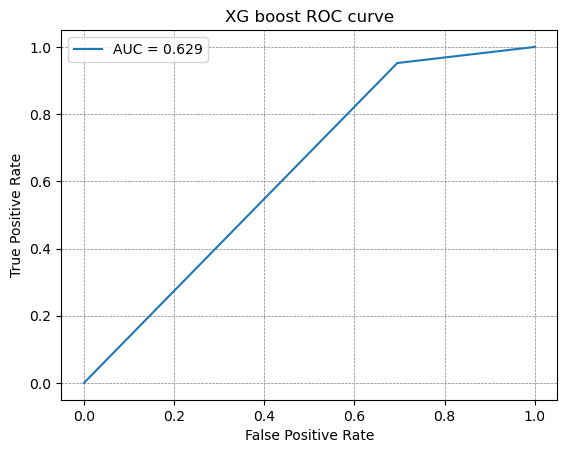

In [24]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test_s,  y_pred_s)
auc = metrics.roc_auc_score(y_test_s, y_pred_s)
plt.plot(fpr,tpr, label=f'AUC = {auc:.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('XG boost ROC curve')
plt.grid(linestyle='--', linewidth=0.5, color='gray')
plt.legend()
plt.savefig('photos/auc.png', transparent=True)
plt.show()

Podsumowując, sieć f-AnoGAN najlepsze wyniki uzyskuje gdy jest trenowana na znormalizowanych, uciętych zdjęciach. Do określania czy dane zdjęcie zawiera anomalie (raka) proponujemy punkt odcięcia obliczany ze wzoru: (mean(anomaly_score(Xn)) + mean(anomaly_score(Xr))) * 0.2375, gdzie Xn to dane normalne a Xr to dane z rakiem.   

### Funkcja straty

In [65]:
df_loss = pd.read_csv('results_cropped_15_15/train_wgangp_log.csv')

In [66]:
df_loss

,Epoch,Batch,D loss,G loss
0,0,0,9.149370,0.018484
1,0,5,8.950006,0.019874
2,0,10,8.702471,0.017430
3,0,15,8.272492,0.015588
4,0,20,7.664326,0.012816
...,...,...,...,...
3070,14,1000,0.378563,4.259316
3071,14,1005,1.114080,2.966803
3072,14,1010,0.054179,4.037617
3073,14,1015,0.528216,3.028854


In [67]:
loss_agg = df_loss.groupby('Epoch').aggregate('mean')
loss_agg

,Batch,D loss,G loss
Epoch,,,
0,510.0,-0.615983,-1.992022
1,510.0,-0.157944,-2.404661
2,510.0,-0.148436,-0.382026
3,510.0,-0.276617,0.844795
4,510.0,-0.487514,0.076156
5,510.0,-0.566847,1.267874
6,510.0,-0.955354,1.519786
7,510.0,-0.899929,0.648676
8,510.0,-0.402948,0.992795


In [68]:
df[df['label']==1].loc[:,'anomaly_score']

1        0.096608
3        0.068767
4        0.096980
6        0.089021
7        0.108155
           ...   
32762    0.133988
32763    0.076566
32764    0.077496
32765    0.127681
32766    0.204682
Name: anomaly_score, Length: 16377, dtype: float64

In [69]:
loss_agg.loc[:,"D loss"]

Epoch
0    -0.615983
1    -0.157944
2    -0.148436
3    -0.276617
4    -0.487514
5    -0.566847
6    -0.955354
7    -0.899929
8    -0.402948
9    -0.288314
10   -0.283919
11   -0.344779
12   -0.495109
13   -0.566984
14   -0.487104
Name: D loss, dtype: float64

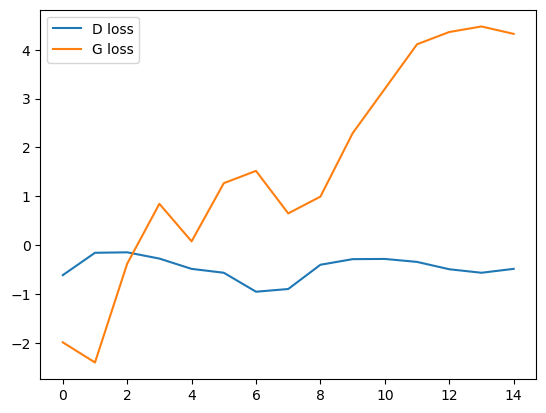

In [70]:
plt.plot(loss_agg['D loss'], label = 'D loss')
plt.plot(loss_agg['G loss'], label = 'G loss')
plt.legend()
plt.savefig('photos/loss2.png', transparent=True)
plt.show()

In [71]:
df_loss2 = pd.read_csv('results_cropped_15_15/train_encoder_log.csv')

In [72]:
eloss_agg = df_loss2.groupby('Epoch').aggregate('mean')
eloss_agg

,Batch,E loss
Epoch,,
0,510.0,0.217658
1,510.0,0.155668
2,510.0,0.141528
3,510.0,0.132255
4,510.0,0.126587
5,510.0,0.123048
6,510.0,0.120149
7,510.0,0.118357
8,510.0,0.116590


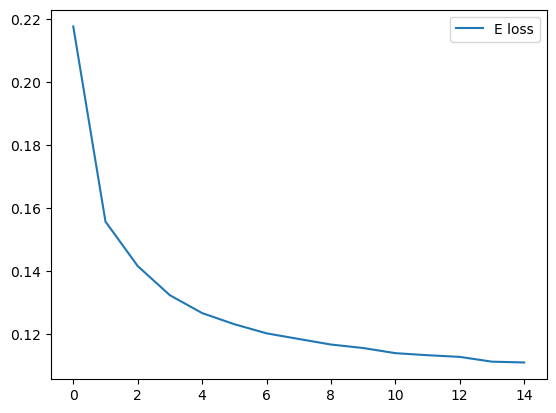

In [73]:
plt.plot(eloss_agg['E loss'], label = 'E loss')
plt.legend()
plt.savefig('photos/loss3.png', transparent=True)
plt.show()

### Raport

Funkcje do generowania wykresów i danych do raportu

In [25]:
def numerical_results(df):
    df_results = pd.DataFrame()
    df_results['label'] = [0, 1]
    df_results['mean_anomaly_score'] = df.groupby('label').aggregate('mean')['anomaly_score']
    df_results['median_an_sc'] = df.groupby('label').aggregate('median')['anomaly_score']
    df_results['max_an_sc'] = df.groupby('label').aggregate('max')['anomaly_score']
    df_results['mean_img_distance'] = df.groupby('label').aggregate('mean')['img_distance']
    df_results['mean_z_distance'] = df.groupby('label').aggregate('mean')['z_distance']
    df_results.set_index('label', inplace=True)
    print(df_results)

In [26]:
def save_histogram(name, df):
    plt.hist(df[df['label'] == 0]['anomaly_score'], bins=50, range=(0, 0.5), label='Normal', alpha=0.8)
    plt.hist(df[df['label'] == 1]['anomaly_score'], bins=50, range=(0, 0.5), label='Cancer', alpha=0.8)
    plt.legend()
    plt.savefig(f'photos/{name}.png', transparent=True)
    plt.show()

Default
       mean_anomaly_score  median_an_sc  max_an_sc  mean_img_distance  \
label                                                                   
0                0.121854      0.125204   1.686141           0.089908   
1                0.131875      0.126825   0.419204           0.099668   

       mean_z_distance  
label                   
0             0.016945  
1             0.019300  


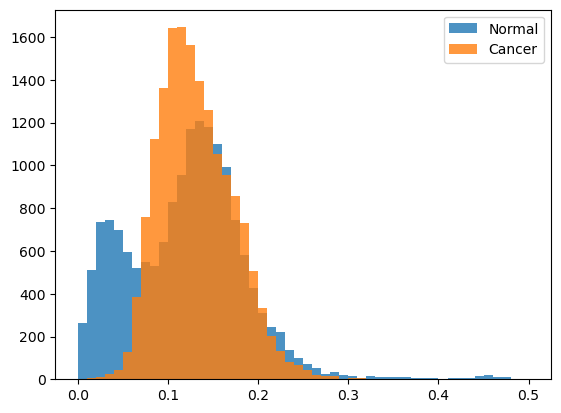

Cropped15
       mean_anomaly_score  median_an_sc  max_an_sc  mean_img_distance  \
label                                                                   
0                0.099689      0.100745   0.746071           0.077066   
1                0.112805      0.103960   0.542333           0.079009   

       mean_z_distance  
label                   
0             0.027754  
1             0.032142  


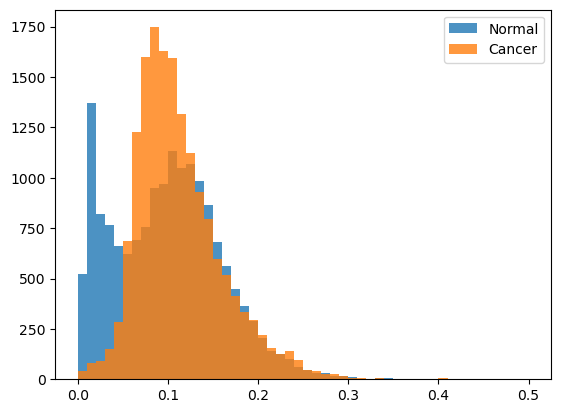

Cropped7
       mean_anomaly_score  median_an_sc  max_an_sc  mean_img_distance  \
label                                                                   
0                0.106780      0.104006   0.483460           0.071663   
1                0.104986      0.098597   0.448402           0.067080   

       mean_z_distance  
label                   
0             0.017217  
1             0.016655  


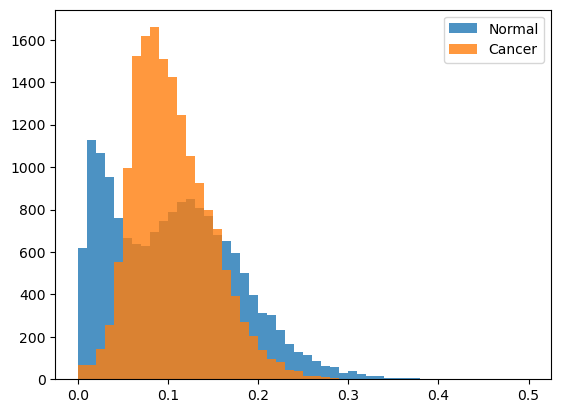

Validation
       mean_anomaly_score  median_an_sc  max_an_sc  mean_img_distance  \
label                                                                   
0                0.107628      0.105604   1.281195           0.071921   
1                0.107537      0.097927   0.380977           0.074518   

       mean_z_distance  
label                   
0             0.018298  
1             0.017721  


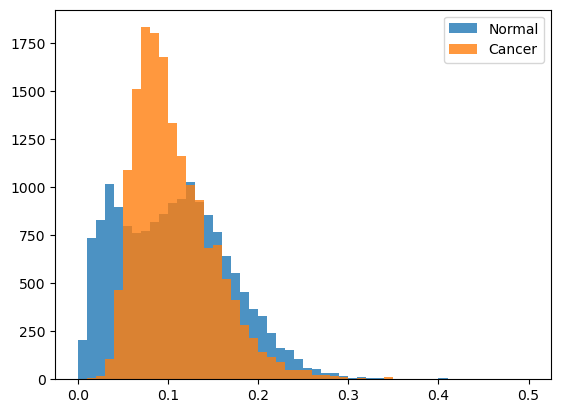

StainNet
       mean_anomaly_score  median_an_sc  max_an_sc  mean_img_distance  \
label                                                                   
0                0.107470      0.111191   0.382624           0.083987   
1                0.105713      0.101831   0.351290           0.081707   

       mean_z_distance  
label                   
0             0.018523  
1             0.019859  


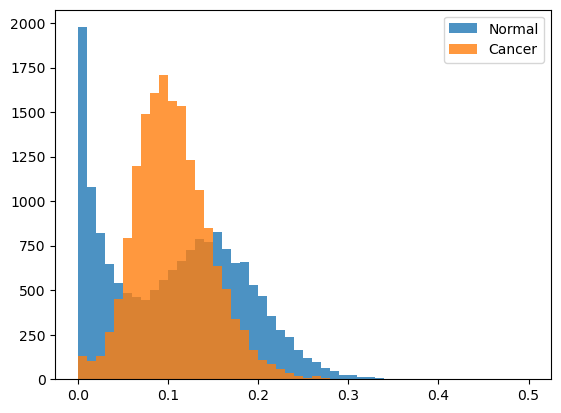

In [321]:
df1 = pd.read_csv('results_default_30_20/score.csv')
df2 = pd.read_csv('results_cropped_15_15/score.csv')
df3 = pd.read_csv('results_cropped_7_10/score.csv')
df4 = pd.read_csv('results_validation_50_20/scorev.csv')
df5 = pd.read_csv('results_stain_net/score.csv')
df4.columns = ['label', 'img_distance', 'anomaly_score', 'z_distance']
data_frames = [df1, df2, df3, df4, df5]
names = ['Default', 'Cropped15', 'Cropped7', 'Validation', 'StainNet']
data = list(zip(names, data_frames))
for name, df in data:
    print(name)
    numerical_results(df)
    save_histogram(name, df)